# 验证集mAp曲线

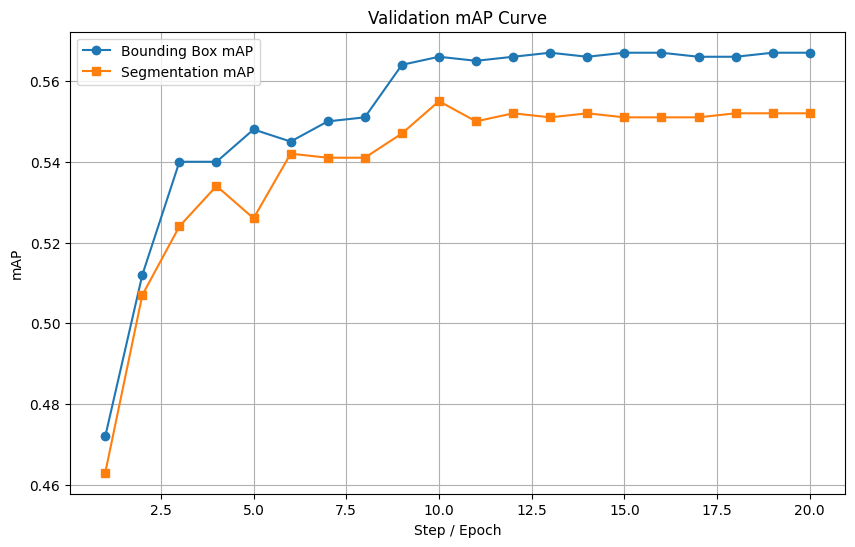

In [1]:
import json
import matplotlib.pyplot as plt

# 加载 scalars.json 文件
with open("/home/wangminlu/HW2/mmdetection/work_dirs/mask-rcnn_r50_fpn_1x_voc0712/20250524_213230/vis_data/scalars.json", 'r') as f:
    data = [json.loads(line) for line in f]

# 提取 mAP 数据和对应的 step
steps = []
bbox_mAPs = []
segm_mAPs = []

for entry in data:
    if 'coco/bbox_mAP' in entry and 'coco/segm_mAP' in entry and 'step' in entry:
        steps.append(entry['step'])
        bbox_mAPs.append(entry['coco/bbox_mAP'])
        segm_mAPs.append(entry['coco/segm_mAP'])

# 绘制 mAP 曲线
plt.figure(figsize=(10, 6))
plt.plot(steps, bbox_mAPs, label='Bounding Box mAP', marker='o')
plt.plot(steps, segm_mAPs, label='Segmentation mAP', marker='s')

plt.title('Validation mAP Curve')
plt.xlabel('Step / Epoch')
plt.ylabel('mAP')
plt.legend()
plt.grid(True)
plt.show()

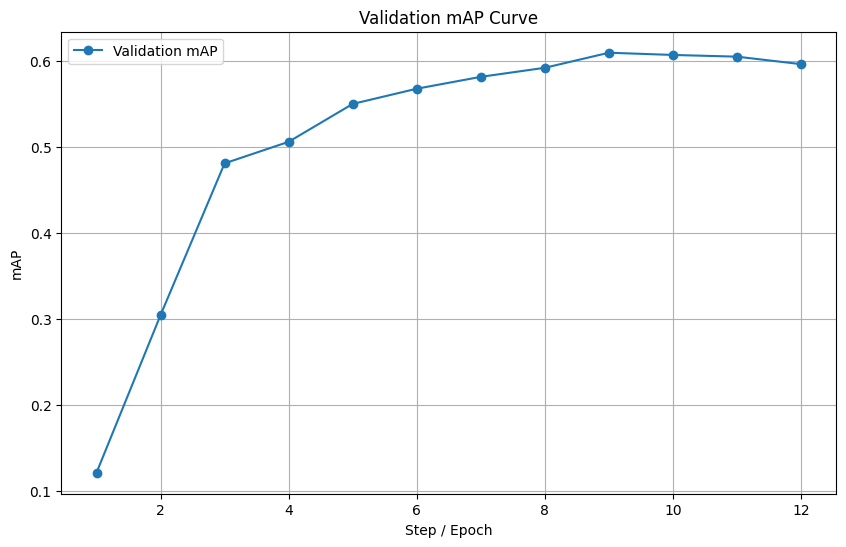

In [2]:
import json
import matplotlib.pyplot as plt

# 加载 scalars.json 文件
file_path = "/home/wangminlu/HW2/mmdetection/work_dirs/sparse-rcnn_r50_fpn_1x_voc0712/20250525_093742/vis_data/scalars.json"

with open(file_path, 'r') as f:
    lines = f.readlines()

# 解析每一行 JSON 数据
data = []
for line in lines:
    try:
        data.append(json.loads(line.strip()))
    except:
        continue

# 提取 mAP 数据和对应的 step
steps = []
mAPs = []

for entry in data:
    if 'pascal_voc/mAP' in entry and 'step' in entry:
        steps.append(entry['step'])
        mAPs.append(entry['pascal_voc/mAP'])

# 绘制 mAP 曲线
plt.figure(figsize=(10, 6))
plt.plot(steps, mAPs, label='Validation mAP', marker='o', linestyle='-')

plt.title('Validation mAP Curve')
plt.xlabel('Step / Epoch')
plt.ylabel('mAP')
plt.legend()
plt.grid(True)
plt.show()

# 结果可视化

In [11]:
import cv2
import torch

In [ ]:
from mmdet.apis import init_detector, inference_detector
import mmcv

# 配置文件路径和模型权重路径
mask_rcnn_config = '/home/wangminlu/HW2/mmdetection/configs/pascal_voc/mask-rcnn_r50_fpn_1x_voc0712.py'
mask_rcnn_checkpoint = '/home/wangminlu/HW2/mmdetection/work_dirs/mask-rcnn_r50_fpn_1x_voc0712/epoch_10.pth'
sparse_rcnn_config = '/home/wangminlu/HW2/mmdetection/configs/pascal_voc/sparse-rcnn_r50_fpn_1x_voc0712.py'
sparse_rcnn_checkpoint = '/home/wangminlu/HW2/mmdetection/work_dirs/sparse-rcnn_r50_fpn_1x_voc0712/epoch_9.pth'

# 初始化模型
mask_rcnn_model = init_detector(mask_rcnn_config, mask_rcnn_checkpoint, device='cuda:0')
sparse_rcnn_model = init_detector(sparse_rcnn_config, sparse_rcnn_checkpoint, device='cuda:0')


Loads checkpoint by local backend from path: /home/wangminlu/HW2/mmdetection/work_dirs/mask-rcnn_r50_fpn_1x_voc0712/epoch_10.pth
Loads checkpoint by local backend from path: /home/wangminlu/HW2/mmdetection/work_dirs/sparse-rcnn_r50_fpn_1x_voc0712/epoch_9.pth


- 第一阶段结果

In [39]:
class_names = mask_rcnn_model.dataset_meta['classes']
output_path = '/home/wangminlu/HW2/visualize_result'
import numpy as np
import os
img_paths = [
    '/home/wangminlu/HW2/mmdetection/data/VOCdevkit/VOC2012/JPEGImages/2011_003220.jpg',
    '/home/wangminlu/HW2/mmdetection/data/VOCdevkit/VOC2012/JPEGImages/2011_003254.jpg',
    '/home/wangminlu/HW2/mmdetection/data/VOCdevkit/VOC2012/JPEGImages/2011_003269.jpg',
    '/home/wangminlu/HW2/mmdetection/data/VOCdevkit/VOC2012/JPEGImages/2011_003275.jpg',
]
for img_path in img_paths:
    img = mmcv.imread(img_path)
    # --------- 1. 可视化 proposal box（RPN候选框） ---------
    with torch.no_grad():
        device = next(mask_rcnn_model.parameters()).device
        # 预处理图片为tensor
        img_tensor = torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).float().to(device)
        # 归一化（根据你的config文件设置，若有mean/std请手动归一化）
        img_tensor = img_tensor / 255.0
        # 提取特征
        feats = mask_rcnn_model.extract_feat(img_tensor)
        # 获取proposal（MMDet 3.x RPNHead没有simple_test，直接用forward）
        rpn_outs = mask_rcnn_model.rpn_head(feats)
        proposal_cfg = mask_rcnn_model.test_cfg.rpn
        proposal_list = mask_rcnn_model.rpn_head.predict_by_feat(
            *rpn_outs,
            batch_img_metas=[{'img_shape': img.shape, 'scale_factor': 1.0, 'pad_shape': img.shape, 'ori_shape': img.shape}],
            cfg=proposal_cfg
        )[0].cpu().numpy()
    # 绘制前100个proposal
    proposal_img = img.copy()
    # proposal_list 可能是 InstanceData，需要取 .bboxes
    if hasattr(proposal_list, 'bboxes'):
        proposal_boxes = proposal_list.bboxes
        if hasattr(proposal_boxes, 'cpu'):
            proposal_boxes = proposal_boxes.cpu().numpy()
        else:
            proposal_boxes = np.array(proposal_boxes)
    else:
        proposal_boxes = proposal_list  # 已经是 numpy

    for box in proposal_boxes[:50]:
        x1, y1, x2, y2 = box[:4].astype(int)
        cv2.rectangle(proposal_img, (x1, y1), (x2, y2), (255, 0, 0), 1)
    mmcv.imwrite(proposal_img, os.path.join(output_path, os.path.basename(img_path).replace('.', '_proposal.')))

    # --------- 2. 可视化最终预测结果（检测框/分割） ---------
    result = inference_detector(mask_rcnn_model, img_path)
    pred_instances = result.pred_instances
    bboxes = pred_instances.bboxes.cpu().numpy()
    labels = pred_instances.labels.cpu().numpy()
    scores = pred_instances.scores.cpu().numpy()
    masks = pred_instances.masks.cpu().numpy() if hasattr(pred_instances, 'masks') and pred_instances.masks is not None else None

    vis_img = img.copy()
    color_map = [(0, 255, 0), (0, 0, 255), (255, 0, 0), (255, 255, 0), (0, 255, 255), (255, 0, 255)]
    for idx, bbox in enumerate(bboxes):
        if scores[idx] < 0.5:
            continue
        color = color_map[labels[idx] % len(color_map)]
        x1, y1, x2, y2 = bbox.astype(int)
        cv2.rectangle(vis_img, (x1, y1), (x2, y2), color, 2)
        label_text = f'{class_names[labels[idx]]}: {scores[idx]:.2f}'
        cv2.putText(vis_img, label_text, (x1, max(y1 - 5, 0)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        if masks is not None:
            mask = masks[idx].astype(np.uint8)
            contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(vis_img, contours, -1, color, 2)
            vis_img[mask > 0] = vis_img[mask > 0] * 0.5 + np.array(color) * 0.5

    mmcv.imwrite(vis_img, os.path.join(output_path, os.path.basename(img_path).replace('.', '_final.')))

print(f'proposal和最终预测结果已保存到 {output_path}')

proposal和最终预测结果已保存到 /home/wangminlu/HW2/visualize_result


In [41]:
for img_path in img_paths:
    img = mmcv.imread(img_path)
    result = inference_detector(mask_rcnn_model, img_path)
    pred_instances = result.pred_instances
    bboxes = pred_instances.bboxes.cpu().numpy()
    labels = pred_instances.labels.cpu().numpy()
    scores = pred_instances.scores.cpu().numpy()
    bboxes_with_scores = np.hstack([bboxes, scores[:, None]])

    # 可视化检测框
    mmcv.imshow_det_bboxes(
        img.copy(), bboxes_with_scores, labels, class_names=class_names,
        score_thr=0.3, show=False,
        out_file=os.path.join(output_path, os.path.basename(img_path).replace('.', '_det.'))
    )

    # 可视化分割掩码（手动叠加）
    if hasattr(pred_instances, 'masks') and pred_instances.masks is not None:
        segms = pred_instances.masks.cpu().numpy()
        seg_img = img.copy()
        color_map = [(0, 255, 0), (0, 0, 255), (255, 0, 0), (255, 255, 0)]  # 你可以自定义颜色
        for idx, mask in enumerate(segms):
            if scores[idx] < 0.5:
                continue
            color = color_map[labels[idx] % len(color_map)]
            mask = mask.astype(np.uint8) * 255
            contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(seg_img, contours, -1, color, 2)
            seg_img[mask > 0] = seg_img[mask > 0] * 0.5 + np.array(color) * 0.5  # 半透明叠加
        mmcv.imwrite(seg_img, os.path.join(output_path, os.path.basename(img_path).replace('.', '_seg.')))

print(f'可视化结果已保存到 {output_path}')

可视化结果已保存到 /home/wangminlu/HW2/visualize_result


In [42]:
for img_path in img_paths:
    img = mmcv.imread(img_path)
    result = inference_detector(sparse_rcnn_model, img_path)
    pred_instances = result.pred_instances
    bboxes = pred_instances.bboxes.cpu().numpy()
    labels = pred_instances.labels.cpu().numpy()
    scores = pred_instances.scores.cpu().numpy()
    bboxes_with_scores = np.hstack([bboxes, scores[:, None]])

    # 可视化检测框
    mmcv.imshow_det_bboxes(
        img.copy(), bboxes_with_scores, labels, class_names=class_names,
        score_thr=0.3, show=False,
        out_file=os.path.join(output_path, os.path.basename(img_path).replace('.', '_s_det.'))
    )

    # 可视化分割掩码（手动叠加）
    if hasattr(pred_instances, 'masks') and pred_instances.masks is not None:
        segms = pred_instances.masks.cpu().numpy()
        seg_img = img.copy()
        color_map = [(0, 255, 0), (0, 0, 255), (255, 0, 0), (255, 255, 0)]  # 你可以自定义颜色
        for idx, mask in enumerate(segms):
            if scores[idx] < 0.5:
                continue
            color = color_map[labels[idx] % len(color_map)]
            mask = mask.astype(np.uint8) * 255
            contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(seg_img, contours, -1, color, 2)
            seg_img[mask > 0] = seg_img[mask > 0] * 0.5 + np.array(color) * 0.5  # 半透明叠加
        mmcv.imwrite(seg_img, os.path.join(output_path, os.path.basename(img_path).replace('.', '_s_seg.')))

print(f'可视化结果已保存到 {output_path}')

可视化结果已保存到 /home/wangminlu/HW2/visualize_result


In [ ]:
img_paths = [
    '/home/wangminlu/HW2/visualize_result/cat.jpg',
    '/home/wangminlu/HW2/visualize_result/dog.jpg',
    '/home/wangminlu/HW2/visualize_result/horse.jpg'
]
for img_path in img_paths:
    img = mmcv.imread(img_path)
    result = inference_detector(mask_rcnn_model, img_path)
    pred_instances = result.pred_instances
    bboxes = pred_instances.bboxes.cpu().numpy()
    labels = pred_instances.labels.cpu().numpy()
    scores = pred_instances.scores.cpu().numpy()
    bboxes_with_scores = np.hstack([bboxes, scores[:, None]])

    # 可视化检测框
    mmcv.imshow_det_bboxes(
        img.copy(), bboxes_with_scores, labels, class_names=class_names,
        score_thr=0.3, show=False,
        out_file=os.path.join(output_path, os.path.basename(img_path).replace('.', '_m_det.'))
    )

    # 可视化分割掩码（手动叠加）
    if hasattr(pred_instances, 'masks') and pred_instances.masks is not None:
        segms = pred_instances.masks.cpu().numpy()
        seg_img = img.copy()
        color_map = [(0, 255, 0), (0, 0, 255), (255, 0, 0), (255, 255, 0)]  # 你可以自定义颜色
        for idx, mask in enumerate(segms):
            if scores[idx] < 0.5:
                continue
            color = color_map[labels[idx] % len(color_map)]
            mask = mask.astype(np.uint8) * 255
            contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(seg_img, contours, -1, color, 2)
            seg_img[mask > 0] = seg_img[mask > 0] * 0.5 + np.array(color) * 0.5  # 半透明叠加
        mmcv.imwrite(seg_img, os.path.join(output_path, os.path.basename(img_path).replace('.', '_m_seg.')))
    
    img = mmcv.imread(img_path)
    result = inference_detector(sparse_rcnn_model, img_path)
    pred_instances = result.pred_instances
    bboxes = pred_instances.bboxes.cpu().numpy()
    labels = pred_instances.labels.cpu().numpy()
    scores = pred_instances.scores.cpu().numpy()
    bboxes_with_scores = np.hstack([bboxes, scores[:, None]])

    # 可视化检测框
    mmcv.imshow_det_bboxes(
        img.copy(), bboxes_with_scores, labels, class_names=class_names,
        score_thr=0.3, show=False,
        out_file=os.path.join(output_path, os.path.basename(img_path).replace('.', '_s_det.'))
    )

    # 可视化分割掩码（手动叠加）
    if hasattr(pred_instances, 'masks') and pred_instances.masks is not None:
        segms = pred_instances.masks.cpu().numpy()
        seg_img = img.copy()
        color_map = [(0, 255, 0), (0, 0, 255), (255, 0, 0), (255, 255, 0)]  # 你可以自定义颜色
        for idx, mask in enumerate(segms):
            if scores[idx] < 0.5:
                continue
            color = color_map[labels[idx] % len(color_map)]
            mask = mask.astype(np.uint8) * 255
            contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(seg_img, contours, -1, color, 2)
            seg_img[mask > 0] = seg_img[mask > 0] * 0.5 + np.array(color) * 0.5  # 半透明叠加
        mmcv.imwrite(seg_img, os.path.join(output_path, os.path.basename(img_path).replace('.', '_s_seg.')))

print(f'可视化结果已保存到 {output_path}')

可视化结果已保存到 /home/wangminlu/HW2/visualize_result


: 